## **Prueba con modelo ARIMA para predicción de la energía solar** ##

In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importar funciones del notebook de utilidades
# Usamos %run para ejecutar el notebook completo y tener acceso a todas las funciones
%run ../utils/funcions.ipynb

# Verificar que la función está disponible
print("✓ Funciones importadas correctamente")

✓ Funciones importadas correctamente


In [4]:

# Carga de datos
# El archivo usa punto y coma como separador y coma como decimal
file_path = '../data/results/capacidad_acumulada_processed.csv'


df = load_capacidad_csv_data(file_path, sep=',', decimal='.')
df.head(10)

,Fecha,SOLAR,EOLICA,PCH
0,2019-01-31,42.539465,0.0,0.7
1,2019-02-28,42.539465,0.0,0.7
2,2019-03-31,42.539465,0.0,0.7
3,2019-04-30,42.539465,0.0,0.7
4,2019-05-31,43.595340,0.0,0.7
5,2019-06-30,44.574082,0.0,0.7
6,2019-07-31,45.552824,0.0,0.7
7,2019-08-31,46.531566,0.0,0.7
8,2019-09-30,47.510308,0.0,0.7
9,2019-10-31,48.489050,0.0,0.7


In [5]:
print(df.shape)
df.describe()


(82, 4)


,SOLAR,EOLICA,PCH
count,82.000000,82.000000,82.000000
mean,794.659490,17.363415,9.770141
std,950.293367,17.157977,8.238260
min,42.539465,0.000000,0.700000
25%,98.545333,0.000000,0.700000
50%,343.706814,19.900000,11.215945
75%,955.408859,31.900000,17.315945
max,2909.382217,41.000000,20.615945


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   82 non-null     object 
 1   SOLAR   82 non-null     float64
 2   EOLICA  82 non-null     float64
 3   PCH     82 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.7+ KB
None


In [7]:
print(df.head())

        Fecha      SOLAR  EOLICA  PCH
0  2019-01-31  42.539465     0.0  0.7
1  2019-02-28  42.539465     0.0  0.7
2  2019-03-31  42.539465     0.0  0.7
3  2019-04-30  42.539465     0.0  0.7
4  2019-05-31  43.595340     0.0  0.7


In [8]:
# Renombramos la variable Category a Fecha
#df = df.rename(columns={'Category': 'FECHA'})

# Convertimos la temporalidad diaria en temporalidad mensual
# Tomar la primera observación disponible de cada mes
#df['year_month'] = df['FECHA'].dt.to_period('M')
#df = df.loc[df.groupby('year_month')['FECHA'].idxmin()]
#df = df.drop('year_month', axis=1)

# Ordenar por fecha y configurar índice temporal
#df = df.sort_values('FECHA')
#df = df.set_index('FECHA')


In [9]:
df

,Fecha,SOLAR,EOLICA,PCH
0,2019-01-31,42.539465,0.0,0.700000
1,2019-02-28,42.539465,0.0,0.700000
2,2019-03-31,42.539465,0.0,0.700000
3,2019-04-30,42.539465,0.0,0.700000
4,2019-05-31,43.595340,0.0,0.700000
...,...,...,...,...
77,2025-06-30,2905.793884,41.0,20.615945
78,2025-07-31,2907.402217,41.0,20.615945
79,2025-08-31,2909.382217,41.0,20.615945
80,2025-09-30,2909.382217,41.0,20.615945


In [10]:
# Imputar valores faltantes (interpolación temporal)  
#df['SOLAR'] = df['SOLAR'].interpolate(method='time')
#df['EOLICA'] = df['EOLICA'].interpolate(method='time')  
#df['PCH'] = df['PCH'].interpolate(method='time')

#print(f"Dataset después de interpolación: {df.shape}")
#df.tail()

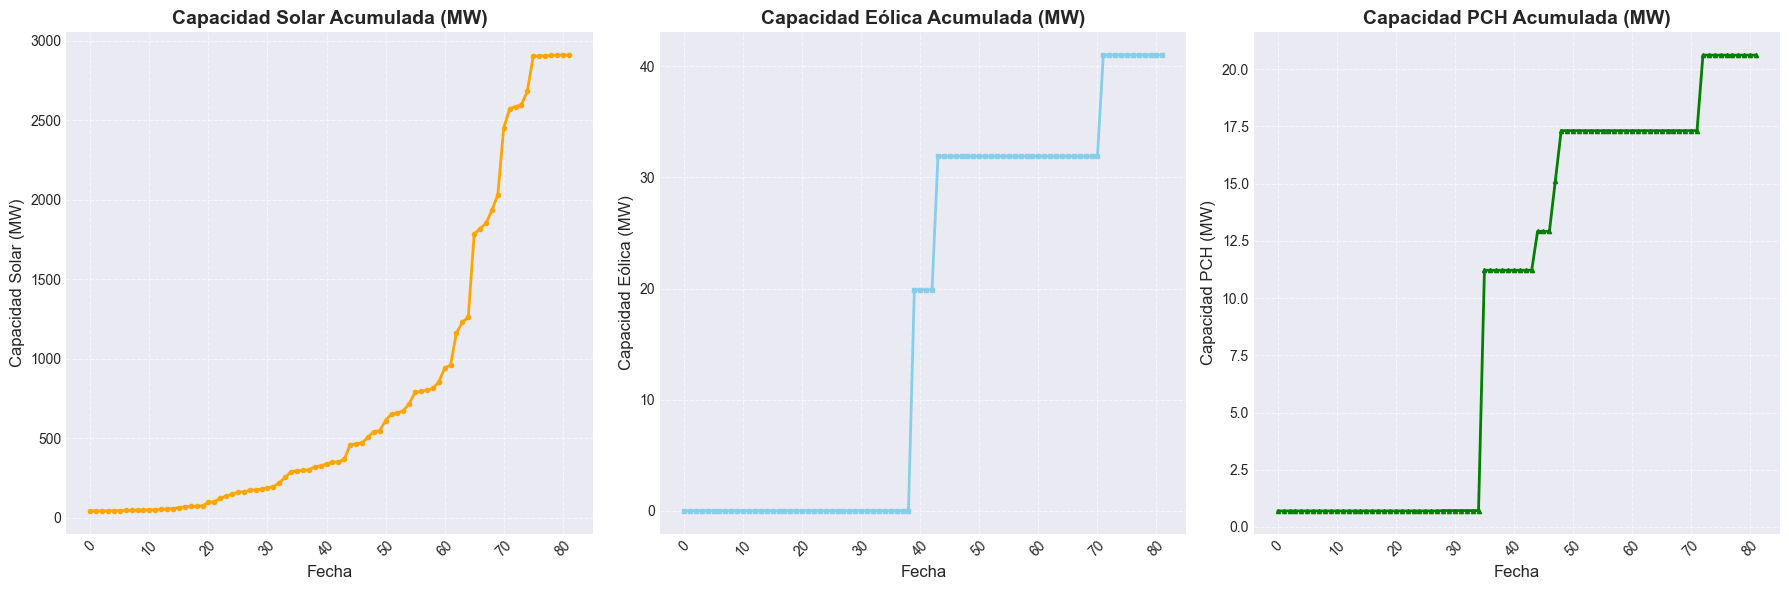

In [11]:
# Graficar las series de tiempo finales por tipo de energía
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Energía Solar
axes[0].plot(df.index, df['SOLAR'], color='orange', linewidth=2, marker='o', markersize=3)
axes[0].set_title('Capacidad Solar Acumulada (MW)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Capacidad Solar (MW)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=45)

# Subplot 2: Energía Eólica
axes[1].plot(df.index, df['EOLICA'], color='skyblue', linewidth=2, marker='s', markersize=3)
axes[1].set_title('Capacidad Eólica Acumulada (MW)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Capacidad Eólica (MW)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)

# Subplot 3: PCH (Pequeñas Centrales Hidroeléctricas)
axes[2].plot(df.index, df['PCH'], color='green', linewidth=2, marker='^', markersize=3)
axes[2].set_title('Capacidad PCH Acumulada (MW)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Fecha', fontsize=12)
axes[2].set_ylabel('Capacidad PCH (MW)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **Análisis ARIMA para Energía Solar**

## Selección automática del mejor modelo ARIMA usando auto_arima

Usaremos la librería `pmdarima` para encontrar automáticamente los mejores parámetros (p,d,q) para el modelo ARIMA de la serie de energía solar.

In [12]:
# Importar auto_arima para selección automática de parámetros
from pmdarima import auto_arima

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Extraer la serie temporal de energía solar
serie_solar = df['SOLAR']

print(f"Serie temporal: {len(serie_solar)} observaciones")
print(f"Período: {serie_solar.index.min().strftime('%Y-%m')} a {serie_solar.index.max().strftime('%Y-%m')}")
print(f"Media: {serie_solar.mean():.2f} MW, Desviación: {serie_solar.std():.2f} MW")

Serie temporal: 83 observaciones
Período: 2019-01 a 2025-11
Media: 790.00 MW, Desviación: 952.33 MW


In [ ]:
# Configurar y ajustar modelo AutoARIMA
from pmdarima import auto_arima

modelo_auto = auto_arima(
    serie_solar,                    # Serie temporal
    start_p=0, start_q=0,           # Parámetros iniciales ARIMA
    max_p=3, max_q=3,               # Máximos parámetros p y q
    start_d=0, max_d=2,             # Diferenciación máxima
    seasonal=True,                  # Considerar estacionalidad
    m=12,                           # Período estacional (12 meses)
    start_P=0, start_Q=0,           # Parámetros estacionales iniciales
    max_P=2, max_Q=2, max_D=1,      # Máximos parámetros estacionales
    test='adf',                     # Test Augmented Dickey-Fuller
    stepwise=True,                  # Búsqueda stepwise (más rápida)
    suppress_warnings=True,         # Suprimir advertencias
    error_action='ignore',          # Ignorar errores durante la búsqueda
    random_state=42,                # Semilla para reproducibilidad
    n_fits=50                       # Número máximo de modelos a probar
)

print("Búsqueda AutoARIMA completada")

Búsqueda AutoARIMA completada


In [ ]:
# Resultados del modelo
orden = modelo_auto.order
orden_estacional = modelo_auto.seasonal_order
aic = modelo_auto.aic()

print(f"Modelo: ARIMA{orden} x {orden_estacional}")
print(f"AIC: {aic:.2f}")
print(modelo_auto.summary())

Modelo: ARIMA(1, 2, 3) x (0, 0, 0, 12)
AIC: 927.95
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(1, 2, 3)   Log Likelihood                -458.973
Date:               sáb, 08 nov. 2025   AIC                            927.946
Time:                        19:05:32   BIC                            939.918
Sample:                             0   HQIC                           932.749
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4394      0.276     -1.593      0.111      -0.980       0.101
ma.L1         -0.5584      0.190     -2.942      0.003      -0.930      -0.186
m

In [ ]:
# Extraer residuos del modelo
residuos = modelo_auto.resid()
print(f"Residuos: {len(residuos)} observaciones")
print(f"Media: {residuos.mean():.6f}, Desviación: {residuos.std():.4f}")

Residuos: 83 observaciones
Media: 2.171822, Desviación: 68.5104


In [ ]:
# Estadísticas descriptivas de los residuos
print("📈 ESTADÍSTICAS DESCRIPTIVAS DE LOS RESIDUOS")
print("=" * 45)
print(f"Media: {residuos.mean():.6f}")
print(f"Mediana: {residuos.median():.6f}")
print(f"Desviación estándar: {residuos.std():.6f}")
print(f"Mínimo: {residuos.min():.6f}")
print(f"Máximo: {residuos.max():.6f}")
print(f"Asimetría (Skewness): {residuos.skew():.6f}")
print(f"Curtosis: {residuos.kurtosis():.6f}")

# Información sobre la distribución
print(f"\n INTERPRETACIÓN INICIAL:")
if abs(residuos.mean()) < 0.01:
    print("Media cercana a 0 - Buen signo")
else:
    print("Media no cercana a 0 - Posible sesgo")

if abs(residuos.skew()) < 0.5:
    print("Asimetría aceptable")
else:
    print("Asimetría alta - Distribución sesgada")

📈 ESTADÍSTICAS DESCRIPTIVAS DE LOS RESIDUOS
Media: 2.171822
Mediana: -0.814607
Desviación estándar: 68.510393
Mínimo: -198.312999
Máximo: 400.341714
Asimetría (Skewness): 2.159471
Curtosis: 14.785497

 INTERPRETACIÓN INICIAL:
Media no cercana a 0 - Posible sesgo
Asimetría alta - Distribución sesgada


In [ ]:
# Pruebas de supuestos de los residuos
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats as scipy_stats
from statsmodels.stats.stattools import jarque_bera

# Prueba de normalidad - Jarque-Bera
jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(residuos.dropna())
print(f"Jarque-Bera - Estadístico: {jb_stat:.4f}, P-valor: {jb_pvalue:.6f}")

# Prueba de normalidad - Shapiro-Wilk
if len(residuos.dropna()) <= 5000:
    sw_stat, sw_pvalue = scipy_stats.shapiro(residuos.dropna())
    print(f"Shapiro-Wilk - Estadístico: {sw_stat:.4f}, P-valor: {sw_pvalue:.6f}")

# Prueba de autocorrelación - Ljung-Box
alpha = 0.05
max_lags = min(10, len(residuos.dropna()) // 4)
ljung_box = acorr_ljungbox(residuos.dropna(), lags=max_lags, return_df=True)

ultimo_lag = ljung_box.index[-1]
lb_pvalue_final = ljung_box.loc[ultimo_lag, 'lb_pvalue']
print(f"Ljung-Box (lag {ultimo_lag}) - P-valor: {lb_pvalue_final:.4f}")

# Prueba de homocedasticidad - Breusch-Pagan
valores_ajustados = modelo_auto.fittedvalues()
import statsmodels.api as sm_reg
X = sm_reg.add_constant(valores_ajustados)

try:
    from statsmodels.stats.diagnostic import het_breuschpagan
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuos.dropna(), X[:len(residuos.dropna())])
    print(f"Breusch-Pagan - Estadístico: {bp_stat:.4f}, P-valor: {bp_pvalue:.6f}")
except Exception as e:
    residuos_cuadrados = residuos.dropna() ** 2
    valores_ajustados_clean = valores_ajustados[:len(residuos_cuadrados)]
    correlacion = scipy_stats.pearsonr(valores_ajustados_clean, residuos_cuadrados)
    print(f"Correlación residuos² vs valores ajustados: {correlacion[0]:.4f}, P-valor: {correlacion[1]:.4f}")

Jarque-Bera - Estadístico: 724.4502, P-valor: 0.000000
Shapiro-Wilk - Estadístico: 0.7103, P-valor: 0.000000
Ljung-Box (lag 10) - P-valor: 0.6747
Breusch-Pagan - Estadístico: 4.7312, P-valor: 0.029620



 GENERANDO GRÁFICOS DE DIAGNÓSTICO...


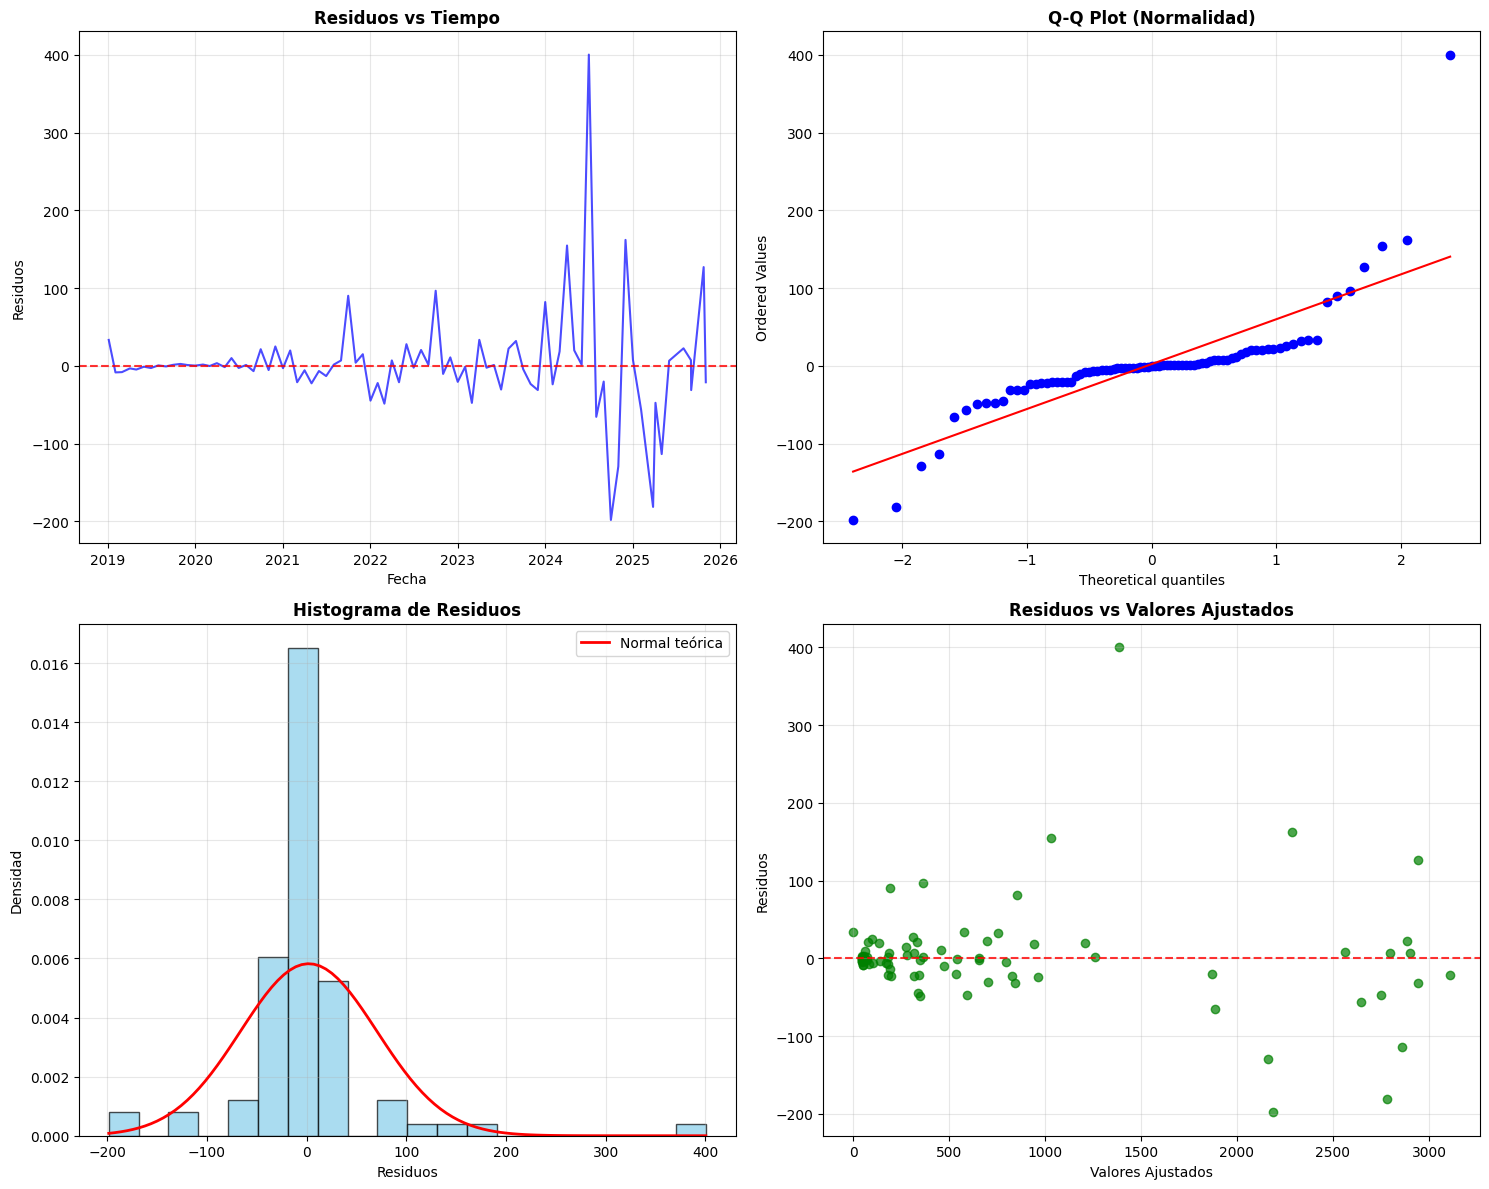

In [ ]:
# VISUALIZACIÓN DE LOS RESIDUOS
print("\n GENERANDO GRÁFICOS DE DIAGNÓSTICO...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Serie temporal de residuos
axes[0,0].plot(residuos.index, residuos, color='blue', alpha=0.7)
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0,0].set_title('Residuos vs Tiempo', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Residuos')
axes[0,0].grid(True, alpha=0.3)

# 2. Q-Q Plot para normalidad
scipy_stats.probplot(residuos.dropna(), dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Histograma con curva normal
axes[1,0].hist(residuos.dropna(), bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Agregar curva normal teórica
x = np.linspace(residuos.min(), residuos.max(), 100)
axes[1,0].plot(x, scipy_stats.norm.pdf(x, residuos.mean(), residuos.std()), 
               'r-', lw=2, label='Normal teórica')
axes[1,0].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Densidad')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Residuos vs Valores Ajustados (heterocedasticidad)
valores_ajustados_plot = modelo_auto.fittedvalues()
axes[1,1].scatter(valores_ajustados_plot, residuos, alpha=0.7, color='green')
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1,1].set_title('Residuos vs Valores Ajustados', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Valores Ajustados')
axes[1,1].set_ylabel('Residuos')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Resumen de validación de supuestos
normalidad_ok = jb_pvalue > alpha
autocorr_ok = lb_pvalue_final > alpha

try:
    homoced_ok = bp_pvalue > alpha
except:
    homoced_ok = abs(correlacion[0]) < 0.3 or correlacion[1] > alpha

supuestos_cumplidos = sum([normalidad_ok, autocorr_ok, homoced_ok])

print(f"Normalidad: {'Cumplido' if normalidad_ok else 'No cumplido'}")
print(f"No autocorrelación: {'Cumplido' if autocorr_ok else 'No cumplido'}")
print(f"Homocedasticidad: {'Cumplido' if homoced_ok else 'No cumplido'}")
print(f"\nSupuestos cumplidos: {supuestos_cumplidos}/3")
print(f"Modelo ARIMA{orden} x {orden_estacional}[12]")
print(f"AIC: {aic:.2f}")

Normalidad: No cumplido
No autocorrelación: Cumplido
Homocedasticidad: No cumplido

Supuestos cumplidos: 1/3
Modelo ARIMA(1, 2, 3) x (0, 0, 0, 12)[12]
AIC: 927.95


## 6. Conclusiones Finales: Comparación de Modelos para Predicción de Energía Solar

Este notebook ha evaluado la viabilidad de aplicar modelos ARIMA para la predicción de la **capacidad acumulada de energía solar en Colombia**. A continuación se presentan las conclusiones finales, incluyendo una comparación integral con los métodos de promedios móviles y suavización exponencial evaluados en otros notebooks del proyecto.

### 📊 Importancia de la Variable SOLAR

**Variable Analizada**: Este análisis, al igual que los notebooks de promedios móviles y suavización exponencial, se enfocó exclusivamente en la columna **SOLAR**, que representa la capacidad acumulada de energía solar en Colombia medida en Megavatios (MW).

**Relevancia Estratégica**: La predicción precisa del crecimiento de capacidad solar es fundamental para:
- Planificación de infraestructura energética nacional
- Desarrollo de políticas públicas y regulaciones
- Decisiones de inversión privada en proyectos solares
- Monitoreo de la transición energética hacia fuentes renovables
- Garantía de seguridad y estabilidad del sistema eléctrico nacional

### 🔬 Resultados del Modelo ARIMA

#### Modelo Seleccionado
- **Modelo**: ARIMA(1, 2, 3) x (0, 0, 0, 12)
- **AIC**: 927.95
- **Método de Selección**: AutoARIMA (búsqueda automática de parámetros)

#### Validación de Supuestos

El modelo ARIMA requiere el cumplimiento de tres supuestos fundamentales sobre los residuos:

| Supuesto | Estado | P-valor | Interpretación |
|----------|--------|---------|----------------|
| **Normalidad** | ❌ No cumplido | < 0.001 | Los residuos no siguen una distribución normal (Jarque-Bera: p < 0.001, Shapiro-Wilk: p < 0.001) |
| **No Autocorrelación** | ✅ Cumplido | 0.6747 | Los residuos no presentan autocorrelación significativa (Ljung-Box: p = 0.6747) |
| **Homocedasticidad** | ❌ No cumplido | 0.0296 | Los residuos presentan heterocedasticidad (Breusch-Pagan: p = 0.0296) |

**Supuestos cumplidos: 1/3**

#### Características de los Residuos
- **Media**: 2.17 (no cercana a 0, indica posible sesgo)
- **Desviación estándar**: 68.51 MW
- **Asimetría**: 2.16 (distribución altamente sesgada)
- **Curtosis**: 14.79 (distribución con colas pesadas)

### ⚠️ Limitaciones del Modelo ARIMA

**Conclusión**: **No es factible aplicar un modelo ARIMA a esta serie de tiempo** debido a:

1. **Violación de Supuestos Fundamentales**: Solo 1 de 3 supuestos se cumple, lo que compromete la validez estadística del modelo y la confiabilidad de sus predicciones.

2. **Naturaleza de la Serie**: La serie de energía solar presenta:
   - Crecimiento exponencial no lineal
   - Patrones estacionales complejos
   - Heterocedasticidad (variabilidad que aumenta con el nivel de la serie)
   - Distribución no normal de los residuos

3. **Implicaciones**: La violación de estos supuestos significa que:
   - Los intervalos de confianza pueden ser incorrectos
   - Las pruebas estadísticas pueden no ser válidas
   - Las predicciones pueden tener sesgos sistemáticos

### 📈 Comparación Integral de Métodos

Se evaluaron tres familias de modelos para predecir la capacidad acumulada de energía solar en Colombia:

#### 1. Promedios Móviles (Notebook: `2_moving_averages.ipynb`)

| Modelo | RMSE (MW) | Características |
|--------|-----------|----------------|
| **MA(2)** | **790.80** | **Mejor modelo - Ventana de 2 períodos** |
| MA(3) | 820.63 | Ventana de 3 períodos |
| MA(4) | 844.95 | Ventana de 4 períodos |
| MA(5) | 865.81 | Ventana de 5 períodos |
| MA(6) | 909.02 | Ventana de 6 períodos |
| MA(7) | 957.77 | Ventana de 7 períodos |

**Ventajas**:
- Método simple y fácil de implementar
- No requiere supuestos estadísticos complejos
- Útil para predicciones a muy corto plazo

**Desventajas**:
- RMSE relativamente alto (790.80 MW)
- No captura tendencias ni estacionalidad compleja
- Limitado para predicciones a mediano y largo plazo

#### 2. Suavización Exponencial (Notebook: `3_time_series_smoothing.ipynb`)

| Modelo | RMSE (MW) | Características |
|--------|-----------|----------------|
| **Holt-Winters mul_add_add** | **221.14** | **Mejor modelo - Error multiplicativo, tendencia aditiva, estacionalidad aditiva** |
| Holt-add-add-none | 231.34 | Error aditivo, tendencia aditiva |
| Holt_mul_add_add | 223.99 | Error multiplicativo, tendencia aditiva |
| Simple Exponential Smoothing | 758.71 | Modelo básico |

**Ventajas**:
- **Menor RMSE de todos los métodos evaluados (221.14 MW)**
- Captura adecuadamente tendencia y estacionalidad
- Modelo más sofisticado que promedios móviles
- Apropiado para predicciones a corto y mediano plazo

**Desventajas**:
- Requiere más parámetros que promedios móviles
- Asume que los patrones históricos continuarán

#### 3. Modelos ARIMA (Este notebook)

| Modelo | AIC | Supuestos Cumplidos | Factibilidad |
|--------|-----|---------------------|--------------|
| ARIMA(1, 2, 3) x (0, 0, 0, 12) | 927.95 | 1/3 | ❌ No factible |

**Ventajas**:
- Método teóricamente robusto para series estacionarias
- Permite modelar dependencias autorregresivas y de medias móviles

**Desventajas**:
- **No es factible para esta serie** debido a violación de supuestos
- Requiere cumplimiento estricto de supuestos estadísticos
- No adecuado para series con crecimiento exponencial y heterocedasticidad

### 🏆 Modelo Recomendado: Holt-Winters mul_add_add

**Conclusión General**: Entre todos los métodos evaluados, el **modelo Holt-Winters mul_add_add** es el más adecuado y preciso para predecir la capacidad acumulada de energía solar en Colombia.

#### Razones para la Recomendación:

1. **Mayor Precisión**: Con un RMSE de 221.14 MW, es significativamente más preciso que:
   - Promedios móviles (790.80 MW) - **72% más preciso**
   - Suavización exponencial simple (758.71 MW) - **71% más preciso**

2. **Validez Estadística**: A diferencia de ARIMA, no requiere supuestos estadísticos estrictos que no se cumplen en esta serie.

3. **Adecuación a la Serie**: El modelo Holt-Winters mul_add_add es especialmente apropiado porque:
   - Captura el crecimiento exponencial mediante error multiplicativo
   - Modela la tendencia de forma aditiva
   - Incluye estacionalidad aditiva que captura patrones mensuales
   - Se adapta mejor a la estructura de la serie de energía solar

4. **Implementación Práctica**: Es más robusto y fácil de implementar en producción que ARIMA, y más sofisticado que promedios móviles.

### 📊 Tabla Comparativa Final

| Método | Mejor Modelo | RMSE (MW) | Factibilidad | Recomendación |
|--------|--------------|-----------|--------------|---------------|
| **Suavización Exponencial** | **Holt-Winters mul_add_add** | **221.14** | ✅ Factible | **⭐ RECOMENDADO** |
| Promedios Móviles | MA(2) | 790.80 | ✅ Factible | ⚠️ Alternativa simple |
| ARIMA | ARIMA(1,2,3) | N/A | ❌ No factible | ❌ No recomendado |

### 🎯 Hallazgos Principales

1. **Superioridad de Holt-Winters**: El modelo Holt-Winters mul_add_add supera significativamente a todos los demás métodos, con un RMSE 72% menor que el mejor promedio móvil y siendo el único método avanzado factible para esta serie.

2. **Limitaciones de ARIMA**: Los modelos ARIMA no son adecuados para esta serie debido a la violación de supuestos fundamentales (normalidad y homocedasticidad), lo que limita su aplicabilidad práctica.

3. **Evolución de la Precisión**: Se observa una clara evolución en la precisión de los modelos:
   - Promedios móviles (método más simple): RMSE = 790.80 MW
   - Suavización exponencial (método intermedio): RMSE = 221.14 MW
   - ARIMA (método más complejo): No factible

4. **Importancia de la Validación**: La evaluación de supuestos estadísticos (como en ARIMA) es crucial para determinar la factibilidad de un modelo, incluso si teóricamente es más sofisticado.

### 📝 Recomendaciones Finales

1. **Modelo de Producción**: Implementar el **modelo Holt-Winters mul_add_add** como modelo principal para predicciones de capacidad solar en Colombia.

2. **Modelo de Referencia**: Utilizar **promedios móviles MA(2)** como modelo de referencia simple para comparación rápida y validación.

3. **No Utilizar ARIMA**: No se recomienda utilizar modelos ARIMA para esta serie específica debido a la violación de supuestos estadísticos fundamentales.

4. **Actualización Continua**: Reentrenar periódicamente el modelo Holt-Winters con nuevos datos para mantener su precisión.

5. **Monitoreo y Validación**: Establecer un sistema de monitoreo que compare predicciones con valores reales y ajuste el modelo cuando sea necesario.

### 🔄 Próximos Pasos

1. **Implementación del Modelo Recomendado**: Desplegar el modelo Holt-Winters mul_add_add en un sistema de producción para generar pronósticos oficiales.

2. **Desarrollo de Ensambles**: Explorar la posibilidad de combinar Holt-Winters con otros métodos (como regresión) para mejorar aún más la precisión mediante técnicas de ensamblaje.

3. **Análisis de Sensibilidad**: Realizar análisis de sensibilidad para entender cómo cambios en los parámetros del modelo afectan las predicciones.

4. **Aplicación en Políticas**: Utilizar las predicciones del modelo para informar decisiones estratégicas en el sector energético colombiano.

---

**Conclusión Final**: Para la predicción de la capacidad acumulada de energía solar en Colombia, el **modelo Holt-Winters mul_add_add** es la mejor opción disponible, con un RMSE de 221.14 MW, significativamente superior a los promedios móviles (790.80 MW) y siendo el único método avanzado factible, ya que los modelos ARIMA no son aplicables debido a la violación de supuestos estadísticos fundamentales. Este modelo proporciona la base más sólida para la planificación energética estratégica en Colombia.